### Получим данные

In [249]:
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from scipy.stats import poisson
from scipy.stats import ttest_ind

In [250]:
df = pd.read_csv("MERGE_TABLE_STORE_4600.csv", sep=";")

### Пропуски в flag_promo

In [251]:
df.flg_spromo.isnull().sum()

0

In [252]:
df.flg_spromo.value_counts()

0    13594213
1       23101
Name: flg_spromo, dtype: int64

### Получим список товаров, по которым больше всего данных:

In [253]:
id_list = df.product_id.value_counts().nlargest(40).index.tolist()

In [254]:
print(id_list)

[555800, 616400, 564900, 582700, 404500, 589400, 582800, 1518900, 835000, 587400, 617400, 819800, 1843100, 631500, 7562300, 11637400, 3539700, 3540400, 12906800, 4095600, 886100, 4212800, 706600, 9339400, 589700, 625700, 560100, 559800, 490400, 1617800, 744200, 720500, 4285500, 615200, 1453400, 4043300, 571300, 808700, 101300, 6783400]


### Выберем только нужные товары и приводим даты к верному формату, получим dataframe для модели:

In [255]:
df_model = df[df.product_id.isin(id_list)]

Смотрим на тот же флаг промо

In [256]:
df_model.flg_spromo.value_counts()

0    54421
1     1891
Name: flg_spromo, dtype: int64

In [257]:
df_model.loc[:, "curr_date"] = pd.to_datetime(df_model.curr_date)

/home/alexander/PythonProjects/MO/venb/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


### Посчитаем спрос с помощью функций для него

In [258]:
import restore_demand_beta as dem

In [259]:
df_temp = dem.restore_demand(df_model, id_list[0], store_id=4600, method="promo")

In [260]:
df_temp

,product_id,store_id,flg_spromo,s_qty,stock,lambda,demand
2016-01-02,555800,4600,0,1.0,0.0,1.501818,3.0
2016-01-03,555800,4600,0,1.0,-1.0,1.501818,1.0
2016-01-04,555800,4600,0,1.0,-2.0,1.501818,2.0
2016-01-05,555800,4600,0,NaN,-3.0,1.501818,1.0
2016-01-06,555800,4600,0,1.0,-3.0,1.501818,1.0
...,...,...,...,...,...,...,...
2019-12-26,555800,4600,1,NaN,9.0,1.501818,2.0
2019-12-27,555800,4600,1,NaN,9.0,1.501818,2.0
2019-12-28,555800,4600,1,NaN,9.0,1.501818,4.0
2019-12-29,555800,4600,1,NaN,9.0,1.501818,2.0


### Тесты и визуализация:

In [261]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [283]:
_sku_list = df_model.product_id.unique().tolist()
_store_list = df.store_id.unique().tolist()


_dates = pd.to_datetime(df_model.curr_date.unique())
_options = [(d.strftime("%d.%m.%Y"), d) for d in _dates if d.weekday() == 0]

dropdown_store = widgets.Dropdown(
    options=_store_list,
    value=_store_list[0],
    description="Store ID:",
    disabled=False,
)

_dates = pd.to_datetime(df_model.curr_date.unique())
_options = [(d.strftime("%d.%m.%Y"), d) for d in _dates if d.weekday() == 0]
range_date = widgets.SelectionRangeSlider(
    options=_options,
    index=(0, len(_options) - 1),
    description="Date",
    disabled=False,
    layout=widgets.Layout(width="auto"),
)

button_plot = widgets.Button(
    description="Plot",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",
)


def plot_sum(b):
    y1_f, y2_f, y3_f, y5_f, y6_f = {}, {}, {}, {}, {}

    for sku in _sku_list:
        df_predicted = dem.restore_demand(
            df_model, sku, dropdown_store.value, method="promo"
        )
        df_predicted.stock.fillna(method="ffill", inplace=True)

        # Demand predicted by sampling function
        x1 = df_predicted[
            (range_date.value[0] <= df_predicted.index)
            & (df_predicted.index < range_date.value[1])
        ]

        temp1 = dict(zip(x1.index.values, x1["demand"].values))
        y1_f = {
            k: np.nansum([temp1.get(k, 0), y1_f.get(k, 0)])
            for k in set(temp1) | set(y1_f)
        }

        # Real sales
        temp2 = dict(zip(x1.index.values, x1["s_qty"].values))
        y2_f = {
            k: np.nansum([temp2.get(k, 0), y2_f.get(k, 0)])
            for k in set(temp2) | set(y2_f)
        }

        x5 = df_predicted[
            (range_date.value[0] <= df_predicted.index)
            & (df_predicted.index < range_date.value[1])
            & (
                (df_predicted.s_qty > df_predicted.stock)
                & (df_predicted.s_qty.notna())
                & (df_predicted.s_qty > 0)
            )
        ]
        temp5 = dict(zip(x5.index.values, x5["demand"].values))
        y5_f = {
            k: np.nansum([temp5.get(k, 0), y5_f.get(k, 0)])
            for k in set(temp5) | set(y5_f)
        }

        # Deficit periods
        y3 = df_predicted[
            (range_date.value[0] <= df_predicted.index)
            & (df_predicted.index < range_date.value[1])
            & (
                (df_predicted.s_qty == df_predicted.stock)
                | (0 >= df_predicted.stock)
                | (df_predicted.s_qty.isna())
            )
        ].s_qty.values
        y3 = y3 * 0
        y3[np.isnan(y3)] = 0
        y3 = y3 + 1

        x3 = df_predicted[
            (range_date.value[0] <= df_predicted.index)
            & (df_predicted.index < range_date.value[1])
            & (
                (df_predicted.s_qty == df_predicted.stock)
                | (0 >= df_predicted.stock)
                | (df_predicted.s_qty.isna())
            )
        ]

        temp3 = dict(zip(x3.index.values, y3))
        y3_f = {
            k: np.nansum([temp3.get(k, 0), y3_f.get(k, 0)])
            for k in set(temp3) | set(y3_f)
        }

        # Finding promo periods
        x6 = df_predicted[
            (df_predicted.index >= range_date.value[0])
            & (df_predicted.index < range_date.value[1])
            & (df_predicted["flg_spromo"] == 1)
        ].index.values
        y6 = [1] * len(x6)

        temp4 = dict(zip(x6, y6))
        y6_f = {
            k: np.nansum([temp4.get(k, 0), y6_f.get(k, 0)])
            for k in set(temp4) | set(y6_f)
        }

    lists = sorted(y1_f.items())  # sorted by key, return a list of tuples
    x1, y1_f = zip(*lists)

    lists = sorted(y2_f.items())  # sorted by key, return a list of tuples
    x2, y2_f = zip(*lists)
    
    lists = sorted(y5_f.items())  # sorted by key, return a list of tuples
    x5, y5_f = zip(*lists)

    lists = sorted(y3_f.items())  # sorted by key, return a list of tuples
    x3, y3_f = zip(*lists)

    lists = sorted(y6_f.items())  # sorted by key, return a list of tuples
    if lists != []:
        x6, y6_f = zip(*lists)

    # Вывод
    clear_output()
    display(dropdown_store, range_date, button_plot)

    fig, host = plt.subplots(figsize=(15, 7))
    par1 = host.twinx()
    par2 = host.twinx()
    # par3 = host.twinx()

    host.set_ylabel("Amount of products", fontsize="12")
    host.set_xlabel("Dates", fontsize="12")

    # par1.set_ylim(0, 45)
    par1.set_ylabel("Deficit days", fontsize="12")
    par1.yaxis.label.set_color("red")

    par2.spines["right"].set_position(("outward", 60))
    par2.set_ylabel("Promo days", fontsize="12")
    par2.yaxis.label.set_color("lightgreen")

    #     par3.spines['left'].set_position(("axes", -0.1))
    #     par3.yaxis.tick_left()
    #     par3.yaxis.set_label_position("left")
    #     par3.set_ylabel("Реальных продаж", fontsize="12")
    #     par3.yaxis.label.set_color("blue")
    #     par3.spines["left"].set_visible(True)

    (p1,) = host.plot(
        x1,
        y1_f,
        label="Sampled demand 1def",
        c="black",
        alpha=0.25,
    )
    
    (p5,) = host.plot(
        x5, y5_f, label="Sampled demand 0def", c="purple", alpha=0.3
    )
    host.scatter(x5, y5_f, marker="h", c="purple")

    (p2,) = host.plot(
        x2, y2_f, label="Real sales", c="blue", alpha=0.3
    )
    host.scatter(x2, y2_f, marker="x", c="blue")

    (p3,) = par1.plot(
        x3, y3_f, label="Deficit days", c="red", alpha=0.2
    )
    par1.scatter(x3, y3_f, marker=".", c="red")
    lns = [p1, p2, p3, p5]

    if lists != []:
        (p4,) = par2.plot(
            x6, y6_f, label="Promo days", c="lightgreen", alpha=0.2
        )
        par2.scatter(x6, y6_f, marker=".", c="lightgreen")
        lns.append(p4)

    host.legend(handles=lns, loc="best")
    host.set_title(
        f"Demand and real sales for promo days "
        f"[{range_date.value[0].strftime('%d.%m.%Y')}"
        f"-{range_date.value[1].strftime('%d.%m.%Y')}]",
        fontsize="16",
    )
    plt.show()


button_plot.on_click(plot_sum)

In [284]:
_sku_list = df_model.product_id.unique().tolist()
_store_list = df.store_id.unique().tolist()


_dates = pd.to_datetime(df_model.curr_date.unique())
_options = [(d.strftime("%d.%m.%Y"), d) for d in _dates if d.weekday() == 0]

dropdown_store = widgets.Dropdown(
    options=_store_list,
    value=_store_list[0],
    description="Store ID:",
    disabled=False,
)

_dates = pd.to_datetime(df_model.curr_date.unique())
_options = [(d.strftime("%d.%m.%Y"), d) for d in _dates if d.weekday() == 0]
range_date = widgets.SelectionRangeSlider(
    options=_options,
    index=(0, len(_options) - 1),
    description="Date",
    disabled=False,
    layout=widgets.Layout(width="auto"),
)

button_plot_second = widgets.Button(
    description="Plot",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",
)


def plot_sum_window(b):
    y1_f, y2_f, y3_f, y5_f, y6_f = {}, {}, {}, {}, {}

    for sku in _sku_list:
        df_predicted = dem.restore_demand(
            df_model, sku, dropdown_store.value, method="window"
        )
        df_predicted.stock.fillna(method="ffill", inplace=True)

        # Demand predicted by sampling function
        x1 = df_predicted[
            (range_date.value[0] <= df_predicted.index)
            & (df_predicted.index < range_date.value[1])
        ]

        temp1 = dict(zip(x1.index.values, x1["demand"].values))
        y1_f = {
            k: np.nansum([temp1.get(k, 0), y1_f.get(k, 0)])
            for k in set(temp1) | set(y1_f)
        }

        # Real sales
        temp2 = dict(zip(x1.index.values, x1["s_qty"].values))
        y2_f = {
            k: np.nansum([temp2.get(k, 0), y2_f.get(k, 0)])
            for k in set(temp2) | set(y2_f)
        }

        x5 = df_predicted[
            (range_date.value[0] <= df_predicted.index)
            & (df_predicted.index < range_date.value[1])
            & (
                (df_predicted.s_qty > df_predicted.stock)
                & (df_predicted.s_qty.notna())
                & (df_predicted.s_qty > 0)
            )
        ]
        temp5 = dict(zip(x5.index.values, x5["demand"].values))
        y5_f = {
            k: np.nansum([temp5.get(k, 0), y5_f.get(k, 0)])
            for k in set(temp5) | set(y5_f)
        }

        # Deficit periods
        y3 = df_predicted[
            (range_date.value[0] <= df_predicted.index)
            & (df_predicted.index < range_date.value[1])
            & (
                (df_predicted.s_qty == df_predicted.stock)
                | (0 >= df_predicted.stock)
                | (df_predicted.s_qty.isna())
            )
        ].s_qty.values
        y3 = y3 * 0
        y3[np.isnan(y3)] = 0
        y3 = y3 + 1

        x3 = df_predicted[
            (range_date.value[0] <= df_predicted.index)
            & (df_predicted.index < range_date.value[1])
            & (
                (df_predicted.s_qty == df_predicted.stock)
                | (0 >= df_predicted.stock)
                | (df_predicted.s_qty.isna())
            )
        ]

        temp3 = dict(zip(x3.index.values, y3))
        y3_f = {
            k: np.nansum([temp3.get(k, 0), y3_f.get(k, 0)])
            for k in set(temp3) | set(y3_f)
        }

        # Finding promo periods
        x6 = df_predicted[
            (df_predicted.index >= range_date.value[0])
            & (df_predicted.index < range_date.value[1])
            & (df_predicted["flg_spromo"] == 1)
        ].index.values
        y6 = [1] * len(x6)

        temp4 = dict(zip(x6, y6))
        y6_f = {
            k: np.nansum([temp4.get(k, 0), y6_f.get(k, 0)])
            for k in set(temp4) | set(y6_f)
        }

    lists = sorted(y1_f.items())  # sorted by key, return a list of tuples
    x1, y1_f = zip(*lists)

    lists = sorted(y2_f.items())  # sorted by key, return a list of tuples
    x2, y2_f = zip(*lists)

    lists = sorted(y5_f.items())  # sorted by key, return a list of tuples
    x5, y5_f = zip(*lists)

    lists = sorted(y3_f.items())  # sorted by key, return a list of tuples
    x3, y3_f = zip(*lists)

    lists = sorted(y6_f.items())  # sorted by key, return a list of tuples
    if lists != []:
        x6, y6_f = zip(*lists)

    # Вывод
    clear_output()
    display(dropdown_store, range_date, button_plot_second)

    fig, host = plt.subplots(figsize=(15, 7))
    par1 = host.twinx()
    par2 = host.twinx()
    # par3 = host.twinx()

    host.set_ylabel("Amount of products", fontsize="12")
    host.set_xlabel("Dates", fontsize="12")

    # par1.set_ylim(0, 45)
    par1.set_ylabel("Deficit days", fontsize="12")
    par1.yaxis.label.set_color("red")

    par2.spines["right"].set_position(("outward", 60))
    par2.set_ylabel("Promo days", fontsize="12")
    par2.yaxis.label.set_color("lightgreen")

    #     par3.spines['left'].set_position(("axes", -0.1))
    #     par3.yaxis.tick_left()
    #     par3.yaxis.set_label_position("left")
    #     par3.set_ylabel("Реальных продаж", fontsize="12")
    #     par3.yaxis.label.set_color("blue")
    #     par3.spines["left"].set_visible(True)

    (p1,) = host.plot(
        x1,
        y1_f,
        label="Sampled demand 1def",
        c="black",
        alpha=0.25,
    )

    (p5,) = host.plot(
        x5, y5_f, label="Sampled demand 0def", c="purple", alpha=0.3
    )
    host.scatter(x5, y5_f, marker="h", c="purple")

    (p2,) = host.plot(x2, y2_f, label="Real sales", c="blue", alpha=0.3)
    host.scatter(x2, y2_f, marker="x", c="blue")

    (p3,) = par1.plot(x3, y3_f, label="Deficit days", c="red", alpha=0.2)
    par1.scatter(x3, y3_f, marker=".", c="red")
    lns = [p1, p2, p3, p5]

    if lists != []:
        (p4,) = par2.plot(
            x6, y6_f, label="Promo days", c="lightgreen", alpha=0.2
        )
        par2.scatter(x6, y6_f, marker=".", c="lightgreen")
        lns.append(p4)

    host.legend(handles=lns, loc="best")
    host.set_title(
        f"Demand and real sales for window"
        f"[{range_date.value[0].strftime('%d.%m.%Y')}"
        f"-{range_date.value[1].strftime('%d.%m.%Y')}]",
        fontsize="16",
    )
    plt.show()


button_plot_second .on_click(plot_sum_window)

Dropdown(description='Store ID:', options=(4600,), value=4600)

SelectionRangeSlider(description='Date', index=(54, 87), layout=Layout(width='auto'), options=(('04.01.2016', …

Button(description='Plot', icon='check', style=ButtonStyle(), tooltip='Click me')

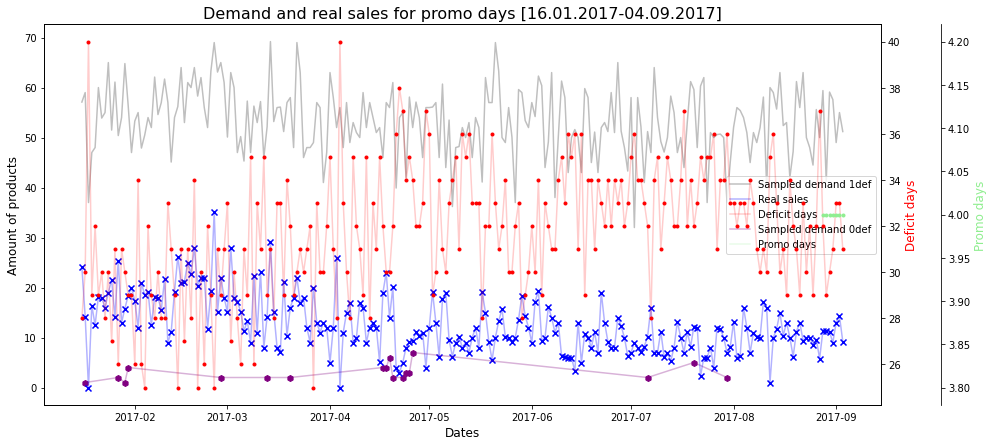

In [285]:
display(dropdown_store, range_date, button_plot)

Dropdown(description='Store ID:', options=(4600,), value=4600)

SelectionRangeSlider(description='Date', index=(72, 103), layout=Layout(width='auto'), options=(('04.01.2016',…

Button(description='Plot', icon='check', style=ButtonStyle(), tooltip='Click me')

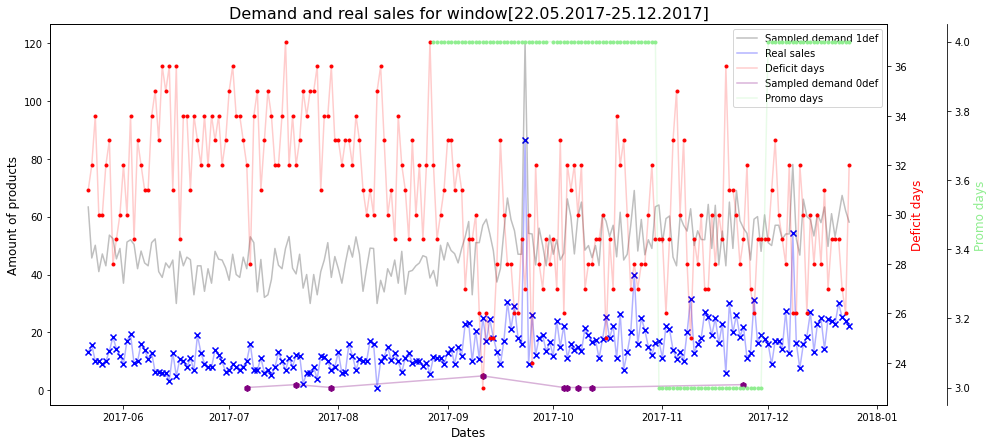

In [286]:
display(dropdown_store, range_date, button_plot_second)

In [276]:
# for i in df_model.product_id.unique():
#     print(df_model.loc[(df_model.product_id == i) & (df_model.curr_date >= "2017-12-07") & (df_model.curr_date <= "2017-12-15")])